In [94]:
import shutil
import polars as pl
from pathlib import Path
# | exporti

import numpy as np
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy.typing as npt
import numpyro
import numpyro.distributions as dist
import polars as pl
import seaborn as sns
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from tqdm import tqdm
from datetime import date
from bayesianfin.simulation import Simulator
from bayesianfin.data import (
    DataLoader,
    FeatureEngineer,
    LogReturn,
    Variance,
    Identity,
    Square,
    append_from_log_ret,
    binary_feature_from_date_ranges,
)
from scipy.stats import norm

In [95]:
base_path = Path("./data")
fns = ["crude_oil.csv", "gasoline_rbob.csv", "heating_oil.csv", "london_gas_oil.csv"]
all_instruments = []
for fn in fns:
    source_df = (
        pl.read_csv(
            base_path / fn,
            infer_schema_length=0,
            dtypes={"Price": pl.Utf8},
            columns=["Date", "Price"],
        )
        .with_columns(
            pl.col("Date").str.to_date(format="%m/%d/%Y"),
            pl.col("Price").str.replace_all(",", "").cast(pl.Float64),
        )
        .rename({"Date": "date", "Price": "price"})
        .with_columns(
            ret=pl.col("price") / pl.col("price").shift(1), instrument=pl.lit(fn)
        )
    )
    feature_engineer = FeatureEngineer(
        transforms=[
            LogReturn(source_field="ret", feature_name="log_ret"),
            Variance(
                source_field="price", feature_name="var", rolling_variance_window=2
            ),
            LogReturn(source_field="var", feature_name="log_var"),
            Identity(source_field="war", feature_name="war"),
        ],
        n_shifts=3,
    )
    df_with_features = feature_engineer.create_features(source_df)
    all_instruments.append(df_with_features)
all_instruments = pl.concat(all_instruments)
all_instruments

/var/folders/8s/q13s1_m56g3b3k_1fmdrwn_80000gn/T/ipykernel_39223/171825147.py:6: DeprecationWarning: The argument `dtypes` for `read_csv` is deprecated. It has been renamed to `schema_overrides`.
  pl.read_csv(


date,price,ret,instrument,log_ret,var,log_var,prev_log_ret_1,prev_log_ret_2,prev_log_ret_3,prev_var_1,prev_var_2,prev_var_3,prev_log_var_1,prev_log_var_2,prev_log_var_3
date,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-04-28,62.05,1.026978,"""crude_oil.csv""",0.02662,1.32845,0.284013,0.037263,-0.012123,0.005446,2.44205,0.25205,0.0512,0.892838,-1.378128,-2.972016
2025-04-25,63.02,1.015633,"""crude_oil.csv""",0.015512,0.47045,-0.754066,0.02662,0.037263,-0.012123,1.32845,2.44205,0.25205,0.284013,0.892838,-1.378128
2025-04-24,62.79,0.99635,"""crude_oil.csv""",-0.003656,0.02645,-3.632499,0.015512,0.02662,0.037263,0.47045,1.32845,2.44205,-0.754066,0.284013,0.892838
2025-04-23,62.27,0.991718,"""crude_oil.csv""",-0.008316,0.1352,-2.001,-0.003656,0.015512,0.02662,0.02645,0.47045,1.32845,-3.632499,-0.754066,0.284013
2025-04-22,64.31,1.032761,"""crude_oil.csv""",0.032235,2.0808,0.732752,-0.008316,-0.003656,0.015512,0.1352,0.02645,0.47045,-2.001,-3.632499,-0.754066
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2010-04-09,707.5,0.992982,"""london_gas_oil.csv""",-0.007042,12.5,2.525729,0.012002,-0.020039,-0.001739,36.125,101.53125,0.78125,3.586985,4.620367,-0.24686
2010-04-08,707.0,0.999293,"""london_gas_oil.csv""",-0.000707,0.125,-2.079442,-0.007042,0.012002,-0.020039,12.5,36.125,101.53125,2.525729,3.586985,4.620367
2010-04-07,715.25,1.011669,"""london_gas_oil.csv""",0.011601,34.03125,3.527279,-0.000707,-0.007042,0.012002,0.125,12.5,36.125,-2.079442,2.525729,3.586985


<Axes: xlabel='price', ylabel='Count'>

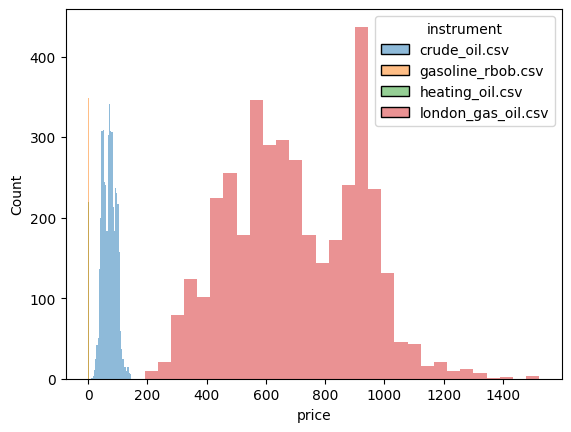

In [101]:
sns.histplot(
    all_instruments,
    x="price",
    hue="instrument",
    common_bins=False,
    common_norm=False,
    cumulative=False,
    # stat="density",
)

<Axes: xlabel='date', ylabel='log_var'>

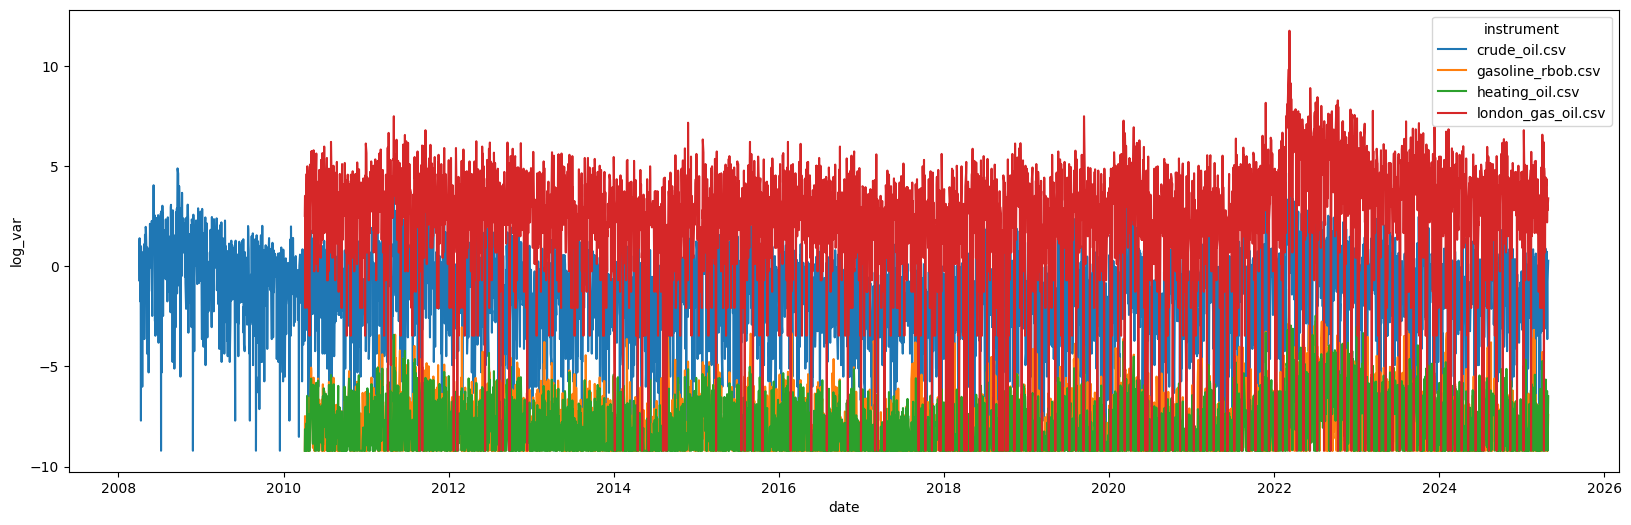

In [115]:
plt.figure(figsize=(20,6))
sns.lineplot(all_instruments, x="date", y="log_var", hue="instrument")

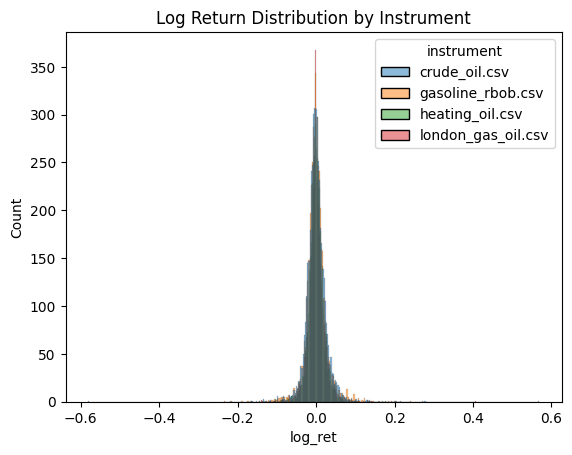

In [117]:
sns.histplot(
    all_instruments.filter(pl.col("log_ret").is_not_null()).to_pandas(),
    x="log_ret",
    hue="instrument",
    kde=False,
    common_bins=False
)
plt.title("Log Return Distribution by Instrument")
plt.show()